# A binomial process

We have a globe representing the earth, and we wish to infer what is the
proportion of the globe covered by water. The experiment we divice to learn
this proportion, is throwing the globe into the air and catching it. When we
catch it, we register whether our index finger is on top of water (W) or
land (L). In the example our observations were: WLWWWLWLW. That is 6 W's out
of 9 tosses.

We assume that the data generating process can be described by sampling from
a binomial distribution. We can then ask, what is the probability of observing
6 W's in 9 tosses given an underlying probabily p, which is the proportion of
water in our globe. We build a likelihood distribution of our data, by
computing the probability of observing 6 W's in 9 tosses for an array of
proprotions of water p.

We assume a prior, which mutliplied they the likelihood yields the
posterior probability distribution. Here we assume a uniform, uniformative
prior that doesn't modify the likelihood.

We also calculate a quadratic approximation to the posterior and compare it
with the grid approximation, and the analytical solution.

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as ss

%matplotlib inline

In [3]:
# Observations
obs = np.array(list('WLWWWLWLW'))
obs[obs == 'W'] = 1
obs[obs == 'L'] = 0
obs = obs.astype(int)

n = len(obs)
k = obs.sum()

## 1. Computing the posterior using a grid approximation

This section shows how to calculate a posterior probability distribution using the grid approximation. Bayes theorem:

$$Pr(\theta|data) = \frac{Pr(data|\theta)\cdot Pr(\theta)}{\int Pr(data|\theta)\,\mathrm{d}\theta}$$

$$Posterior = \frac{Likelihood \cdot Prior}{Evidence}$$

In this specifc example the prior is a vector of ones (uniform prior), which has no influence on the posterior. The likelihood will be the binomial distribution for a vector of $\theta$ values (probabilities of success), and the evidence the integral of the likelihood over all values of $\theta$.

In [147]:
## Grid approximation
points = 50
# Grid of probabilities
p_grid = np.linspace(0, 1, points)

prior = np.ones(points)  # uniform, no apriori information.

# The probability of observing k W's in n tosses over the array of probabilities
likelihood = ss.binom.pmf(  # probability mass function
    k,  # number of successes
    n,  # number of trilas
    p_grid  # probability of success
)

unscaled_posterior = prior * likelihood
posterior = unscaled_posterior / unscaled_posterior.sum()

## Analytical solution
points_highres = 1000
p_grid_highres = np.linspace(0, 1, points_highres)
analytical = ss.beta.pdf(  # probability density function
    p_grid_highres,  # vector of probabilities (x axis)
    k+1,  # alpha (first shape parameter)
    n-k+1  # beta (second shape parameter)
)
analytical = analytical / analytical.sum()

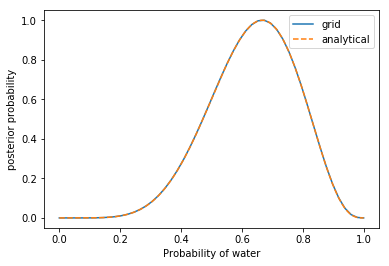

In [148]:
fig, ax = plt.subplots()
# Note the distributions are divided by their max value to make them comparable, even
# when the curves are built with different number of points.
ax.plot(p_grid, posterior / posterior.max(), label='grid')
ax.plot(p_grid_highres, analytical / analytical.max(), ls='--', label='analytical')
ax.set_xlabel('Probability of water')
ax.set_ylabel('posterior probability')
ax.legend();

## 2. Sampling from the posterior probability distribution

One can sample with replacement from the posterior and obtain statistics that describe the posterior.

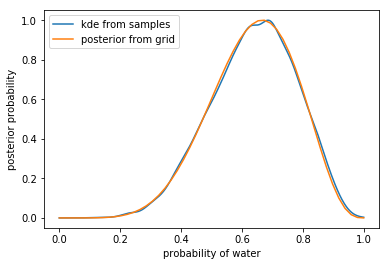

In [149]:
posterior_samples = np.random.choice(
    p_grid,  # vector from which to sample
    p=posterior,  # probability with which to sample the vector
    size=int(1e4),  # size of the sample
    replace=True)

# Kernel density estimation
kernel = ss.gaussian_kde(posterior_samples)
kernel_values = kernel(p_grid_highres)
plt.plot(p_grid_highres, kernel_values / kernel_values.max(), label='kde from samples')
plt.plot(p_grid, posterior / posterior.max(), label='posterior from grid')
plt.legend()
plt.xlabel('probability of water')
plt.ylabel('posterior probability')

### 2.1 Probability of intervals and high-probability density intervals (HDI)

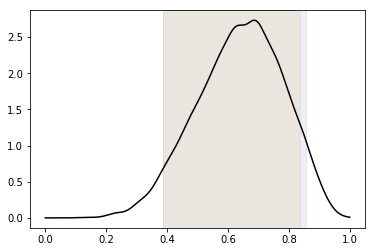

In [192]:
# Almost exaclty the same in a more or less symetric distribution

# Using percentiles
lower_int, upper_int = np.percentile(posterior_samples, [5, 95])
prob_int = sum( (posterior_samples > lower_int) & (posterior_samples < upper_int) ) / len(posterior_samples)

# Using HDI
lower_hpd, upper_hpd = pm.hpd(posterior_samples, alpha=0.1)
prob_hpd = sum( (posterior_samples > lower_hpd) & (posterior_samples < upper_hpd) ) / len(posterior_samples)

plt.plot(p_grid_highres, kernel_values, color='k')
plt.axvspan(lower_int, upper_int, alpha=0.1, color='C0')
plt.axvspan(lower_hpd, upper_hpd, alpha=0.1, color='C1');

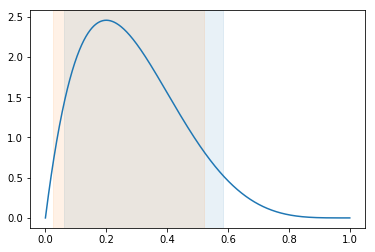

In [200]:
# HPD and percentiles are more different if the distribution is skewed

skewed = ss.beta.pdf(p_grid_highres, 2, 5)
skewed_samples = ss.beta.rvs(  # random variates (a sample)
    2,  # alpha
    5,  # beta
    size=int(1e4)
)

# Using percentiles
lower_int, upper_int = np.percentile(skewed_samples, [5, 95])
prob_int = sum( (skewed_samples > lower_int) & (skewed_samples < upper_int) ) / len(skewed_samples)

# Using HDI
lower_hpd, upper_hpd = pm.hpd(skewed_samples, alpha=0.1)
prob_hpd = sum( (skewed_samples > lower_hpd) & (skewed_samples < upper_hpd) ) / len(skewed_samples)

plt.plot(p_grid_highres, skewed);
plt.axvspan(lower_int, upper_int, alpha=0.1, color='C0')
plt.axvspan(lower_hpd, upper_hpd, alpha=0.1, color='C1');

## 3. Posterior predictive distributions

The posterior samples can be used to generate predictions ditributions for future experiments.

Notice that 6 successes is the most frequent ourcome, but that ther is considerable spread in the predictions.

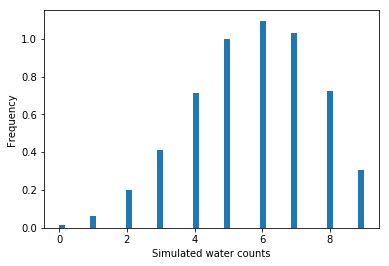

In [206]:
sim = ss.binom.rvs(n=9, p=posterior_samples)
plt.hist(sim, bins=50, density=True)
plt.xlabel('Simulated water counts')
plt.ylabel('Frequency');